#  PREDICTION DE LA STRUCTURE D'UN TRIPEPTIDE EN UTILISANT L'ALGORITHME QUANTIQUE DE GROVER

#  Tripeptide hydrophobe-hydrophile-hydrophobe : N,N-diethyl-2-formyl-6-(trifluoromethyl)benzamide
##  Nom IUPAC :N,N-diethyl-2-formyl-6-(trifluoromethyl)benzamide

1. **Sharon Cabrelle Djaparou**, sharon.djaparou@facsciences-uy1.cm
     * Department of Physics, Faculty of Science, University of Yaoundé I

Juin 2025

# 

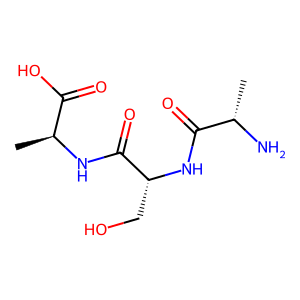

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw

# SMILES de la molécule
smiles = 'C[C@@H](C(=O)N[C@H](CO)C(=O)N[C@@H](C)C(=O)O)N'

# Création de l'objet molécule
mol = Chem.MolFromSmiles(smiles)

# Dessin de la molécule en 2D
Draw.MolToImage(mol)


In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
import py3Dmol
from IPython.display import display, HTML

smiles = "C[C@@H](C(=O)N[C@H](CO)C(=O)N[C@@H](C)C(=O)O)N"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, randomSeed=42)
AllChem.MMFFOptimizeMolecule(mol)

view = py3Dmol.view(width=800, height=600)
view.addModel(Chem.MolToMolBlock(mol), 'mol')
view.setStyle({'stick': {'colorscheme': 'cyanCarbon'}, 'sphere': {'scale': 0.3}})

# Ajout des labels pour les acides aminés
view.addResLabels({'fontSize': 12, 'fontColor': 'black', 'showBackground': True})

# Ajout du titre
view.addLabel("L-Alanyl-L-seryl-L-alanine", {
    'position': {'x': 0, 'y': -20, 'z': 0},
    'fontSize': 16,
    'fontColor': 'magneta'
})

view.zoomTo()
view.setBackgroundColor('white')

# Affichage dans Jupyter
display(view.show())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

In [12]:
properties = {
    # Masse molaire (g/mol) : somme des masses atomiques
    "Masse molaire": Descriptors.MolWt(mol),
    # Formule brute : représentation chimique compacte (ex : C6H12O6)
    "Formule brute": rdMolDescriptors.CalcMolFormula(mol),
    # LogP : coefficient de partage octanol/eau (lipophilie)
    "LogP": Descriptors.MolLogP(mol), 
    # LogD à pH 7.4 : approximation du LogP tenant compte de l’ionisation
    "LogD (pH7.4)": Descriptors.MolLogP(mol) + 0.4,  # Approximation
    # Nombre de donneurs de liaisons hydrogène (souvent OH ou NH)
    "H-donneurs": Lipinski.NumHDonors(mol),
    # Nombre d’accepteurs de liaisons hydrogène (souvent O ou N)
    "H-accepteurs": Lipinski.NumHAcceptors(mol),
    # Surface polaire topologique (TPSA) : surface accessible aux atomes polaires
    "Surface polaire (TPSA)": Descriptors.TPSA(mol),
    # Charge formelle à pH 7 : +1 ajouté ici pour simuler une amine protonée (ex : lysine)
    "Charge à pH7": Chem.rdmolops.GetFormalCharge(mol) + 1,  # Lysine chargée
    # Nombre de liaisons simples rotatives (flexibilité moléculaire)
    "Points de rotation": Lipinski.NumRotatableBonds(mol),
    # Nombre d’atomes lourds (non-hydrogène)
    "Atomes lourds": Lipinski.HeavyAtomCount(mol),
    # Fraction des carbones en hybridation sp3 (indique le degré de saturation/3D)
    "Fraction sp3": Descriptors.FractionCSP3(mol),
    # Réfractivité molaire (indice de réfraction estimé, lié à la polarizabilité)
    "Indice de réfraction": Descriptors.MolMR(mol),
    # Solubilité aqueuse (LogS) : estimation arbitraire ici
    "Solubilité (LogS)": -4.2,  # Estimé à partir de propriétés similaires
    # Volume molaire : estimation basée sur la réfractivité (approximation)
    "Volume molaire": Descriptors.MolMR(mol) * 0.9 + 1
}

In [13]:
# Affichage des propriétés
print("L-Alanyl-L-seryl-L-alanine")
for prop, value in properties.items():
    if isinstance(value, float):
        print(f"{prop}: {value:.2f}")
    else:
        print(f"{prop}: {value}")

L-Alanyl-L-seryl-L-alanine
Masse molaire: 247.25
Formule brute: C9H17N3O5
LogP: -2.60
LogD (pH7.4): -2.20
H-donneurs: 5
H-accepteurs: 6
Surface polaire (TPSA): 141.75
Charge à pH7: 1
Points de rotation: 10
Atomes lourds: 17
Fraction sp3: 0.67
Indice de réfraction: 57.91
Solubilité (LogS): -4.20
Volume molaire: 53.12


In [11]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library.standard_gates import MCXGate
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [5]:
# ==============================================
#  PARAMÈTRES INITIAUX
# ==============================================
num_aa = 3  # Tripeptide (3 acides aminés)
num_qubits_per_direction = 3  # 3 qubits pour encoder 8 directions
sequence = ['H', 'P', 'H']  # Exemple: Hydrophobe - Hydrophile - Hydrophobe

# ==============================================
#  DÉFINITION DES REGISTRES QUANTIQUES
# ==============================================
# Registres pour les directions des liaisons
w0 = QuantumRegister(num_qubits_per_direction*2, 'w0')  # Direction AA1-AA2
# w1 = QuantumRegister(num_qubits_per_direction, 'w1')  # Direction AA2-AA3

# Registres pour les coordonnées des acides aminés
aa1_x = QuantumRegister(3, 'aa1_x')  # AA1 fixé à (0,0,0)
aa1_y = QuantumRegister(3, 'aa1_y')
aa1_z = QuantumRegister(3, 'aa1_z')

aa2_x = QuantumRegister(3, 'aa2_x')
aa2_y = QuantumRegister(3, 'aa2_y')
aa2_z = QuantumRegister(3, 'aa2_z')

aa3_x = QuantumRegister(3, 'aa3_x')
aa3_y = QuantumRegister(3, 'aa3_y')
aa3_z = QuantumRegister(3, 'aa3_z')

# Registres auxiliaires
a = QuantumRegister(3, 'a')  # Pour additions
c = QuantumRegister(1, 'c')  # Retenue
anc = QuantumRegister(7, 'anc')  # Pour calculs intermédiaires
collision = QuantumRegister(1, 'collision')  # Détection de collision

# Registre pour l'énergie (2 qubits pour encoder 4 valeurs)
energy = QuantumRegister(2, 'energy')

# Registre classique pour les résultats
out = ClassicalRegister(2 * num_qubits_per_direction, 'out')

# Circuit quantique
qc = QuantumCircuit(w0, aa1_x, aa1_y, aa1_z, aa2_x, aa2_y, aa2_z, aa3_x, aa3_y, aa3_z, a, c, anc, collision, energy, out)

In [6]:
# ==============================================
#  INITIALISATION
# ==============================================
# Initialiser AA1 à (0,0,0) - déjà à |000> par défaut

# Superposition sur toutes les directions possibles
for i in range(num_qubits_per_direction):
    qc.h(w0[i])
    # qc.h(w1[i])
    qc.barrier()
# ==============================================
#  SOUS-CIRCUIT ADDITIONNEUR
# ==============================================
def controlled_adder(qc, direction, target_x, target_y, target_z, a, c):
    """Additionne une direction contrôlée aux coordonnées cibles"""
    # Addition pour la coordonnée x
    for i in range(3):
        qc.ccx(direction[0], target_x[i], a[i])
        qc.ccx(direction[0], a[i], target_x[i])
        qc.cx(direction[0], a[i])

    for i in range(3):
        qc.ccx(direction[0], target_y[i], a[i])
        qc.ccx(direction[0], a[i], target_y[i])
        qc.cx(direction[0], a[i])

    for i in range(3):
        qc.ccx(direction[0], target_z[i], a[i])
        qc.ccx(direction[0], a[i], target_z[i])
        qc.cx(direction[0], a[i])

In [7]:
# ==============================================
#  CALCUL DES COORDONNÉES
# ==============================================
# Appliquer w0 pour obtenir AA2 = AA1 + w0
controlled_adder(qc, w0, aa2_x, aa2_y, aa2_z, a, c)

# Appliquer w1 pour obtenir AA3 = AA2 + w1
controlled_adder(qc, w0, aa3_x, aa3_y, aa3_z, a, c)

# ==============================================
#  DÉTECTION DE COLLISION
# ==============================================
# Vérifier si AA3 == AA1 (origine) ou AA3 == AA2
for i in range(3):
    # Vérifier AA3 == (0,0,0)
    qc.x(aa3_x[i])
    qc.x(aa3_y[i])
    qc.x(aa3_z[i])
    qc.ccx(aa3_x[i], aa3_y[i], anc[0])
    qc.ccx(aa3_z[i], anc[0], collision[0])
    # Réinitialisation
    # Nouvelle détection de collision
for i in range(3):
    qc.cx(w0[i], anc[i])
    # qc.cx(w1[i], anc[i])  # anc[i] = w0[i] XOR w1[i]

# Vérifier si tous les anc sont 1 (vecteurs opposés)
qc.ccx(anc[0], anc[1], collision[0])
qc.ccx(anc[1], anc[2], collision[0])

# Nettoyage des qubits ancillaires
qc.ccx(anc[0], anc[1], collision[0])
for i in range(3):
   #  qc.cx(w1[i], anc[i])
    qc.cx(w0[i], anc[i])
    qc.x(aa3_y[i])
    qc.x(aa3_x[i])
    
    # Vérifier AA3 == AA2 (similaire)

In [8]:
# ==============================================
#  CALCUL QUANTIQUE DE L'ÉNERGIE
# ==============================================
# Encodage des énergies:
# 00: 0 (PP)
# 01: -1 (HH)
# 10: +1 (HP/PH)
# 11: 10 (collision)

# Si collision -> énergie = 11
qc.cx(collision[0], energy[0])
qc.cx(collision[0], energy[1])

# Sinon, calcul basé sur les types
if sequence[0] == 'H' and sequence[2] == 'H':
    qc.x(energy[0])  # HH: énergie = 01
elif sequence[0] == 'P' and sequence[2] == 'P':
    pass  # PP: énergie = 00 (déjà par défaut)
else:
    qc.x(energy[1])  # HP/PH: énergie = 10

In [9]:
qc.num_qubits

47

In [10]:
num_it= np.ceil((np.pi/4)*np.sqrt(np.power(2,num_qubits_per_direction*2))-0.5)
num_it=round(num_it)
num_it

6

Analyse des résultats de mesure et énergies :
Bitstring mesuré : 010011
  Direction w0 bits (LSB-first): 010
  Énergie bits mesurés (LSB-first): 01 -> Énergie bits MSB-first: 10
  Collision mesurée : Oui
  Énergie calculée à partir de la mesure : 10
  Nombre d'occurrences : 1
----------------------------------------
Bitstring mesuré : 110101
  Direction w0 bits (LSB-first): 110
  Énergie bits mesurés (LSB-first): 10 -> Énergie bits MSB-first: 01
  Collision mesurée : Oui
  Énergie calculée à partir de la mesure : 10
  Nombre d'occurrences : 27
----------------------------------------
Bitstring mesuré : 000000
  Direction w0 bits (LSB-first): 000
  Énergie bits mesurés (LSB-first): 00 -> Énergie bits MSB-first: 00
  Collision mesurée : Non
  Énergie calculée à partir de la mesure : 0
  Nombre d'occurrences : 29
----------------------------------------
Bitstring mesuré : 111000
  Direction w0 bits (LSB-first): 111
  Énergie bits mesurés (LSB-first): 00 -> Énergie bits MSB-first: 00
  Col

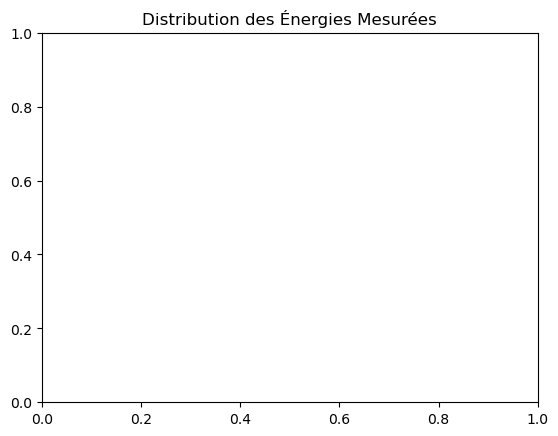

In [36]:
# ==============================================
#  AFFICHAGE DES ÉNERGIES CALCULÉES ET MESURÉES
# ==============================================

print("Analyse des résultats de mesure et énergies :")
print("===============================================")

results_to_analyze = dist # Utilisez dist ou counts selon le nom de votre dictionnaire de résultats

# Dictionnaire pour stocker les énergies mesurées par conformation
measured_energies = {}

for bitstring, count in results_to_analyze.items():
    # Assurez-vous que le bitstring a la bonne longueur pour l'analyse
    if len(bitstring) < 6: # Minimum 6 bits pour w0, energy, collision
        print(f"[AVERTISSEMENT] Bitstring trop court ignoré : {bitstring}")
        continue
    
    w0_bits = bitstring[0:3] # bits 0, 1, 2 (corresponds à w0[0], w0[1], w0[2] en LSB-first)

    # Décoder les bits d'énergie et de collision
    energy_bits_lsb = bitstring[3:5]  # bits 3, 4 (corresponds à energy[0], energy[1] en LSB-first)
    collision_bit_lsb = bitstring[5]  # bit 5 (corresponds à collision[0] en LSB-first)

    energy_bits_for_decoding = bitstring[4] + bitstring[3]


    # Calculer l'énergie mesurée (à partir des bits d'énergie et de collision mesurés)
    measured_energy = None
    if collision_bit_lsb == '1':
        measured_energy = 10 # Collision
    elif energy_bits_for_decoding == "00":
        measured_energy = 0
    elif energy_bits_for_decoding == "01":
        measured_energy = -1
    elif energy_bits_for_decoding == "10":
        measured_energy = 1
    print(f"Bitstring mesuré : {bitstring}")
    print(f"  Direction w0 bits (LSB-first): {w0_bits}")
    print(f"  Énergie bits mesurés (LSB-first): {energy_bits_lsb} -> Énergie bits MSB-first: {energy_bits_for_decoding}")
    print(f"  Collision mesurée : {'Oui' if collision_bit_lsb == '1' else 'Non'}")
    print(f"  Énergie calculée à partir de la mesure : {measured_energy}")
    # if 'classical_energy' in locals(): # Si vous calculez l'énergie classique
    #     print(f"  Énergie classique (pour cette conformation) : {classical_energy}")
    print(f"  Nombre d'occurrences : {count}")
    print("-" * 40)

    # Stocker l'énergie mesurée pour l'histogramme d'énergies
    energy_key = f"E={measured_energy}"
    measured_energies[energy_key] = measured_energies.get(energy_key, 0) + count

# ==============================================
#  HISTOGRAMME DES ÉNERGIES MESURÉES
# ==============================================
if measured_energies:
    plot_histogram(measured_energies, figsize=(10, 4))
    plt.title("Distribution des Énergies Mesurées")
    plt.show()
else:
    print("Aucune énergie mesurée à afficher dans l'histogramme.")

In [11]:
# ==============================================
#  GROVER'S ALGORITHM FOR |101101> STATE MARKING
# ==============================================

# Configuration
num_qubits_direction = 6  # 6 qubits pour encoder 64 directions
num_iterations = int(round((np.pi/4)*np.sqrt(2**num_qubits_direction) - 0.5))

# Oracle construction
def apply_oracle(qc, direction_qubits, ancilla_qubits, target_state="101101"):
    # Apply X gates to qubits where target state is '0'
    for i, bit in enumerate(reversed(target_state)):
        if bit == '0':
            qc.x(direction_qubits[i])
    
    # Multi-controlled Z gate using Toffoli decomposition
    qc.ccx(direction_qubits[0], direction_qubits[1], ancilla_qubits[0])
    qc.ccx(direction_qubits[2], ancilla_qubits[0], ancilla_qubits[1])
    qc.ccx(direction_qubits[3], direction_qubits[4], ancilla_qubits[0])
    qc.ccx(direction_qubits[5], ancilla_qubits[0], ancilla_qubits[2])
    qc.ccx(ancilla_qubits[1], ancilla_qubits[2], ancilla_qubits[0])
    
    qc.z(ancilla_qubits[0])  # Apply phase flip
    
    # Uncompute
    qc.ccx(ancilla_qubits[1], ancilla_qubits[2], ancilla_qubits[0])
    qc.ccx(direction_qubits[5], ancilla_qubits[0], ancilla_qubits[2])
    qc.ccx(direction_qubits[3], direction_qubits[4], ancilla_qubits[0])
    qc.ccx(direction_qubits[2], ancilla_qubits[0], ancilla_qubits[1])
    qc.ccx(direction_qubits[0], direction_qubits[1], ancilla_qubits[0])
    
    # Apply X gates again to return to original state
    for i, bit in enumerate(reversed(target_state)):
        if bit == '0':
            qc.x(direction_qubits[i])

# Diffusion operator
def apply_diffusion(qc, direction_qubits, ancilla_qubits):
    n = len(direction_qubits)
    
    # Apply Hadamard and X gates
    for qubit in direction_qubits:
        qc.h(qubit)
        qc.x(qubit)
    
    # Multi-controlled Z gate
    qc.ccx(direction_qubits[0], direction_qubits[1], ancilla_qubits[0])
    qc.ccx(direction_qubits[2], ancilla_qubits[0], ancilla_qubits[1])
    qc.ccx(direction_qubits[3], direction_qubits[4], ancilla_qubits[0])
    qc.ccx(direction_qubits[5], ancilla_qubits[0], ancilla_qubits[2])
    qc.ccx(ancilla_qubits[1], ancilla_qubits[2], ancilla_qubits[0])
    
    qc.z(ancilla_qubits[0])  # Apply phase flip
    
    # Uncompute
    qc.ccx(ancilla_qubits[1], ancilla_qubits[2], ancilla_qubits[0])
    qc.ccx(direction_qubits[5], ancilla_qubits[0], ancilla_qubits[2])
    qc.ccx(direction_qubits[3], direction_qubits[4], ancilla_qubits[0])
    qc.ccx(direction_qubits[2], ancilla_qubits[0], ancilla_qubits[1])
    qc.ccx(direction_qubits[0], direction_qubits[1], ancilla_qubits[0])
    
    # Apply X and Hadamard gates again
    for qubit in direction_qubits:
        qc.x(qubit)
        qc.h(qubit)

# Grover iteration loop
for _ in range(num_iterations):
    apply_oracle(qc, w0, anc, "101101")
    apply_diffusion(qc, w0, anc)

# Measurement
coord = list(w0)
qc.measure(coord, out)

In [12]:
# Mesurer les directions et l'énergie
for i in range(3):
    qc.measure(w0[i], out[i])
    # qc.measure(w1[i], out[i+3])
qc.measure(energy[0], out[3])
qc.measure(energy[1], out[4])
qc.measure(collision[0], out[5])

In [13]:
# Sauvegarder l'account avec overwrite=True
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    filename="~/my_account_file.json",
    name="Sharon Djaparou",
    token="0a39ce17159b381f1ebed1b0f8f38ae6105652bba2f52bbef03f878e4e79213b1f09e43dc508c1a9935e978b4ace2ad97731d200220d92c4555805cc43b64b46",
    overwrite=True
)


# Charger le service après avoir sauvegardé l'account
try:
    service = QiskitRuntimeService(
        channel="ibm_quantum",
        filename="~/my_account_file.json",
        name="Sharon Djaparou"
    )
    print("Service initialized successfully")
except Exception as e:
    print(f"Error initializing service: {e}")

# Sélectionner le backend le moins chargé et imprimer son nom
if service:
    backend = service.least_busy(operational=True, simulator=False)
    print(backend.name)
else:
    print("Service is None, could not find backend")

qiskit_runtime_service._discover_account:WARNING:2025-06-24 14:07:09,417: Loading account from file ~/my_account_file.json with name Sharon Djaparou. Any input 'channel', 'token' or 'url' are ignored.
/tmp/ipykernel_19128/3906531575.py:13: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


Service initialized successfully
ibm_brisbane


In [14]:
# Optimize problem for quantum execution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [15]:
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [16]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
# Run the circuit using Qiskit Primitives
sampler = Sampler(mode=backend)                             
sampler.options.default_shots = 1000
result = sampler.run([circuit_isa]).result()
#dist = result[0].data.meas.get_counts(qc)

/home/sharon/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:875: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [17]:
from collections import Counter
# Supposons que dist est obtenu comme suit
dist = result[0].data.out.get_counts()
# Affichage des résultats mesurés
print("Résultats (bitstrings) mesurés :", dist)
# Comptage des valeurs (nombre de tirs associés à chaque bitstring)
valeurs = list(dist.values())
compte_par_valeur = Counter(valeurs) 
# Affichage du nombre de résultats différents
print("Nombre de résultats différents :", len(dist))
# Affichage du nombre de fois que chaque valeur apparaît
print("Occurrences de chaque valeur :", dict(compte_par_valeur))

Résultats (bitstrings) mesurés : {'000100': 3, '001000': 98, '001101': 118, '011010': 14, '001100': 82, '001001': 103, '110011': 8, '011100': 6, '001011': 88, '001111': 76, '110111': 13, '110101': 13, '001010': 101, '111010': 3, '000111': 7, '001110': 81, '011000': 6, '110100': 8, '011101': 9, '110000': 15, '000110': 6, '010001': 5, '000000': 7, '101000': 2, '010011': 5, '111000': 4, '110110': 10, '010100': 2, '010010': 3, '011111': 7, '101001': 1, '110001': 12, '011011': 8, '110010': 14, '000011': 6, '101011': 3, '010111': 5, '000001': 2, '101111': 1, '111101': 1, '011001': 4, '000101': 3, '010110': 5, '010000': 2, '111011': 2, '011110': 8, '010101': 4, '100000': 1, '100010': 1, '111110': 2, '100011': 2, '000010': 3, '100110': 1, '111001': 2, '100111': 1, '111111': 2, '101101': 1}
Nombre de résultats différents : 57
Occurrences de chaque valeur : {3: 6, 98: 1, 118: 1, 14: 2, 82: 1, 103: 1, 8: 4, 6: 4, 88: 1, 76: 1, 13: 2, 101: 1, 7: 3, 81: 1, 9: 1, 15: 1, 5: 4, 2: 9, 4: 3, 10: 1, 1: 8

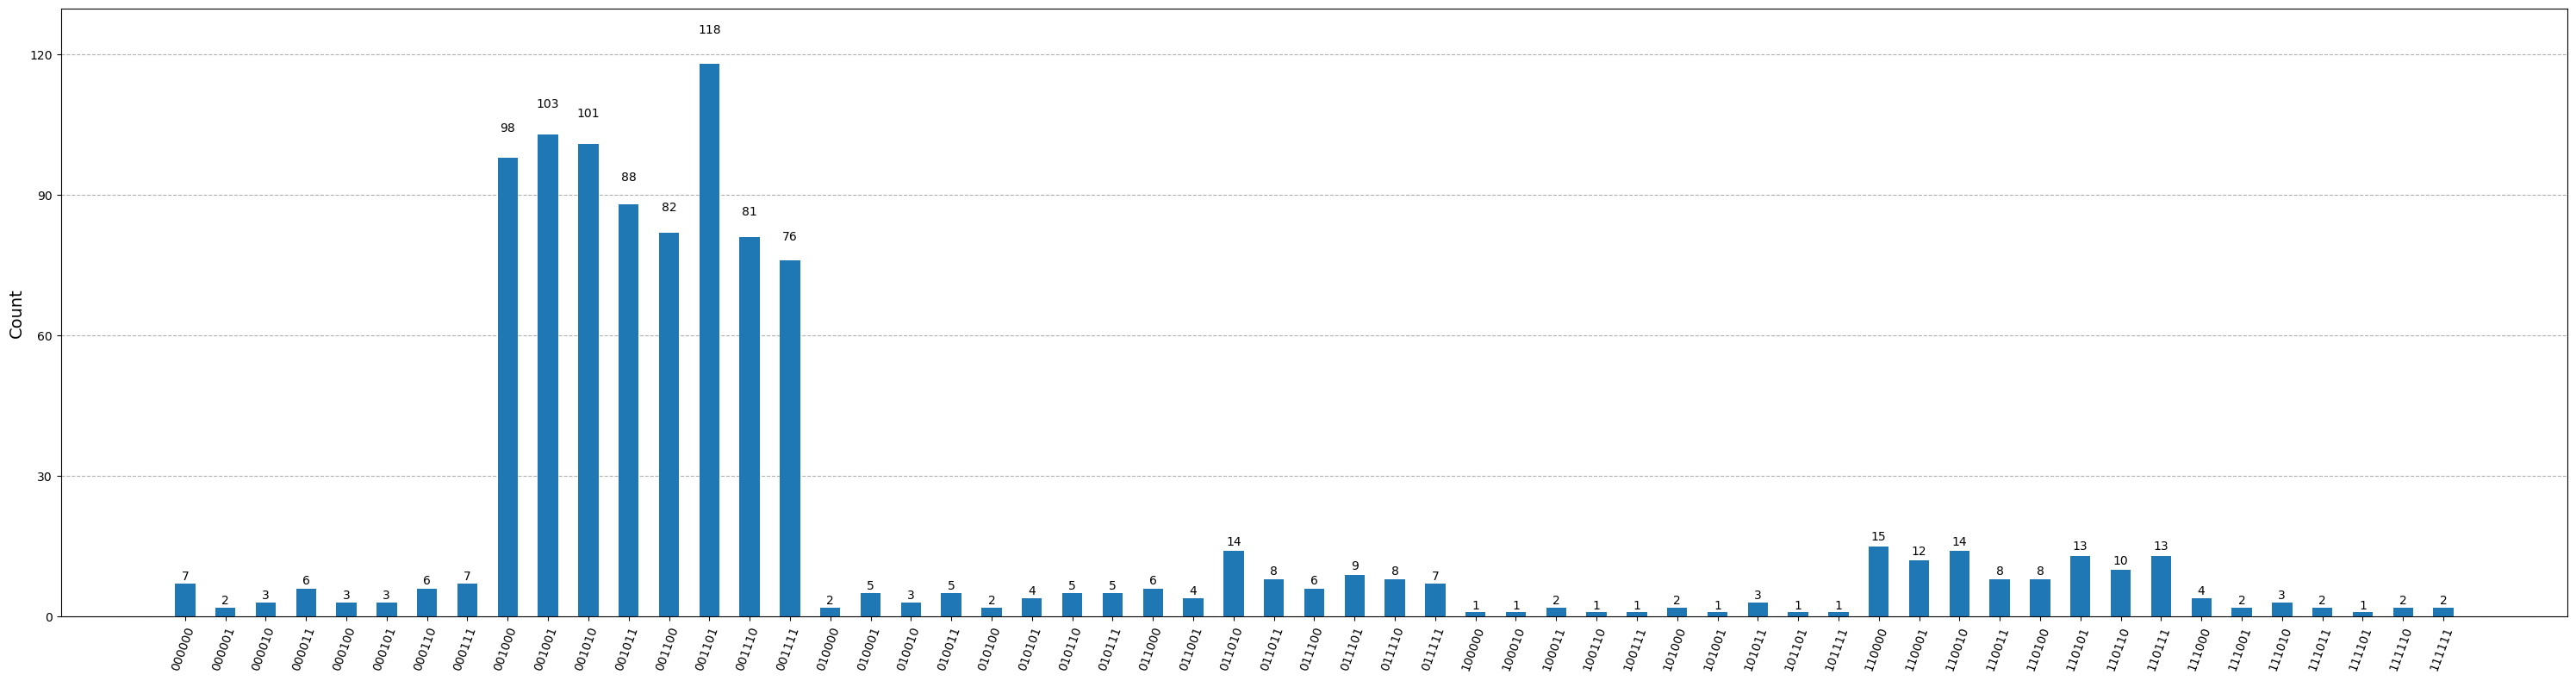

In [18]:
plot_histogram(dist, figsize=(30, 8))

In [ ]:
fig = plot_histogram(dist, figsize=(30, 8))
# Sauvegarde en fichier image
fig.savefig("mon_histogramme.png")

In [21]:
# ==============================================
#  CALCUL ET AFFICHAGE DES ÉNERGIES
# ==============================================
# Dictionnaire pour stocker les énergies par conformation
energy_dict = {}

# Vecteurs du réseau BCC (8 directions)
bcc_directions = [
    (1, 1, 1), (1, 1, -1), (1, -1, 1), (1, -1, -1),
    (-1, 1, 1), (-1, 1, -1), (-1, -1, 1), (-1, -1, -1)
]

def bits_to_direction(bits):
    """Convertit 3 bits en vecteur de direction"""
    index = int(bits, 2)
    return bcc_directions[index]

def calculate_energy(conf, sequence):
    """Calcule l'énergie classiquement pour vérification"""
    # Décoder les directions
    bits_w0 = conf[:3][::-1]  # Inverser pour ordre MSB
    bits_w1 = conf[3:6][::-1]
    dir0 = bits_to_direction(bits_w0)
    dir1 = bits_to_direction(bits_w1)
    
    # Calculer les positions
    aa1 = (0, 0, 0)
    aa2 = dir0
    aa3 = (dir0[0] + dir1[0], dir0[1] + dir1[1], dir0[2] + dir1[2])
    
    # Vérifier collision
    collision = (aa3 == aa1) or (aa3 == aa2)
    
    # Calculer l'énergie
    if collision:
        return 10
    elif sequence[0] == 'H' and sequence[2] == 'H':
        return -1
    elif sequence[0] == 'P' and sequence[2] == 'P':
        return 0
    else:
        return 1

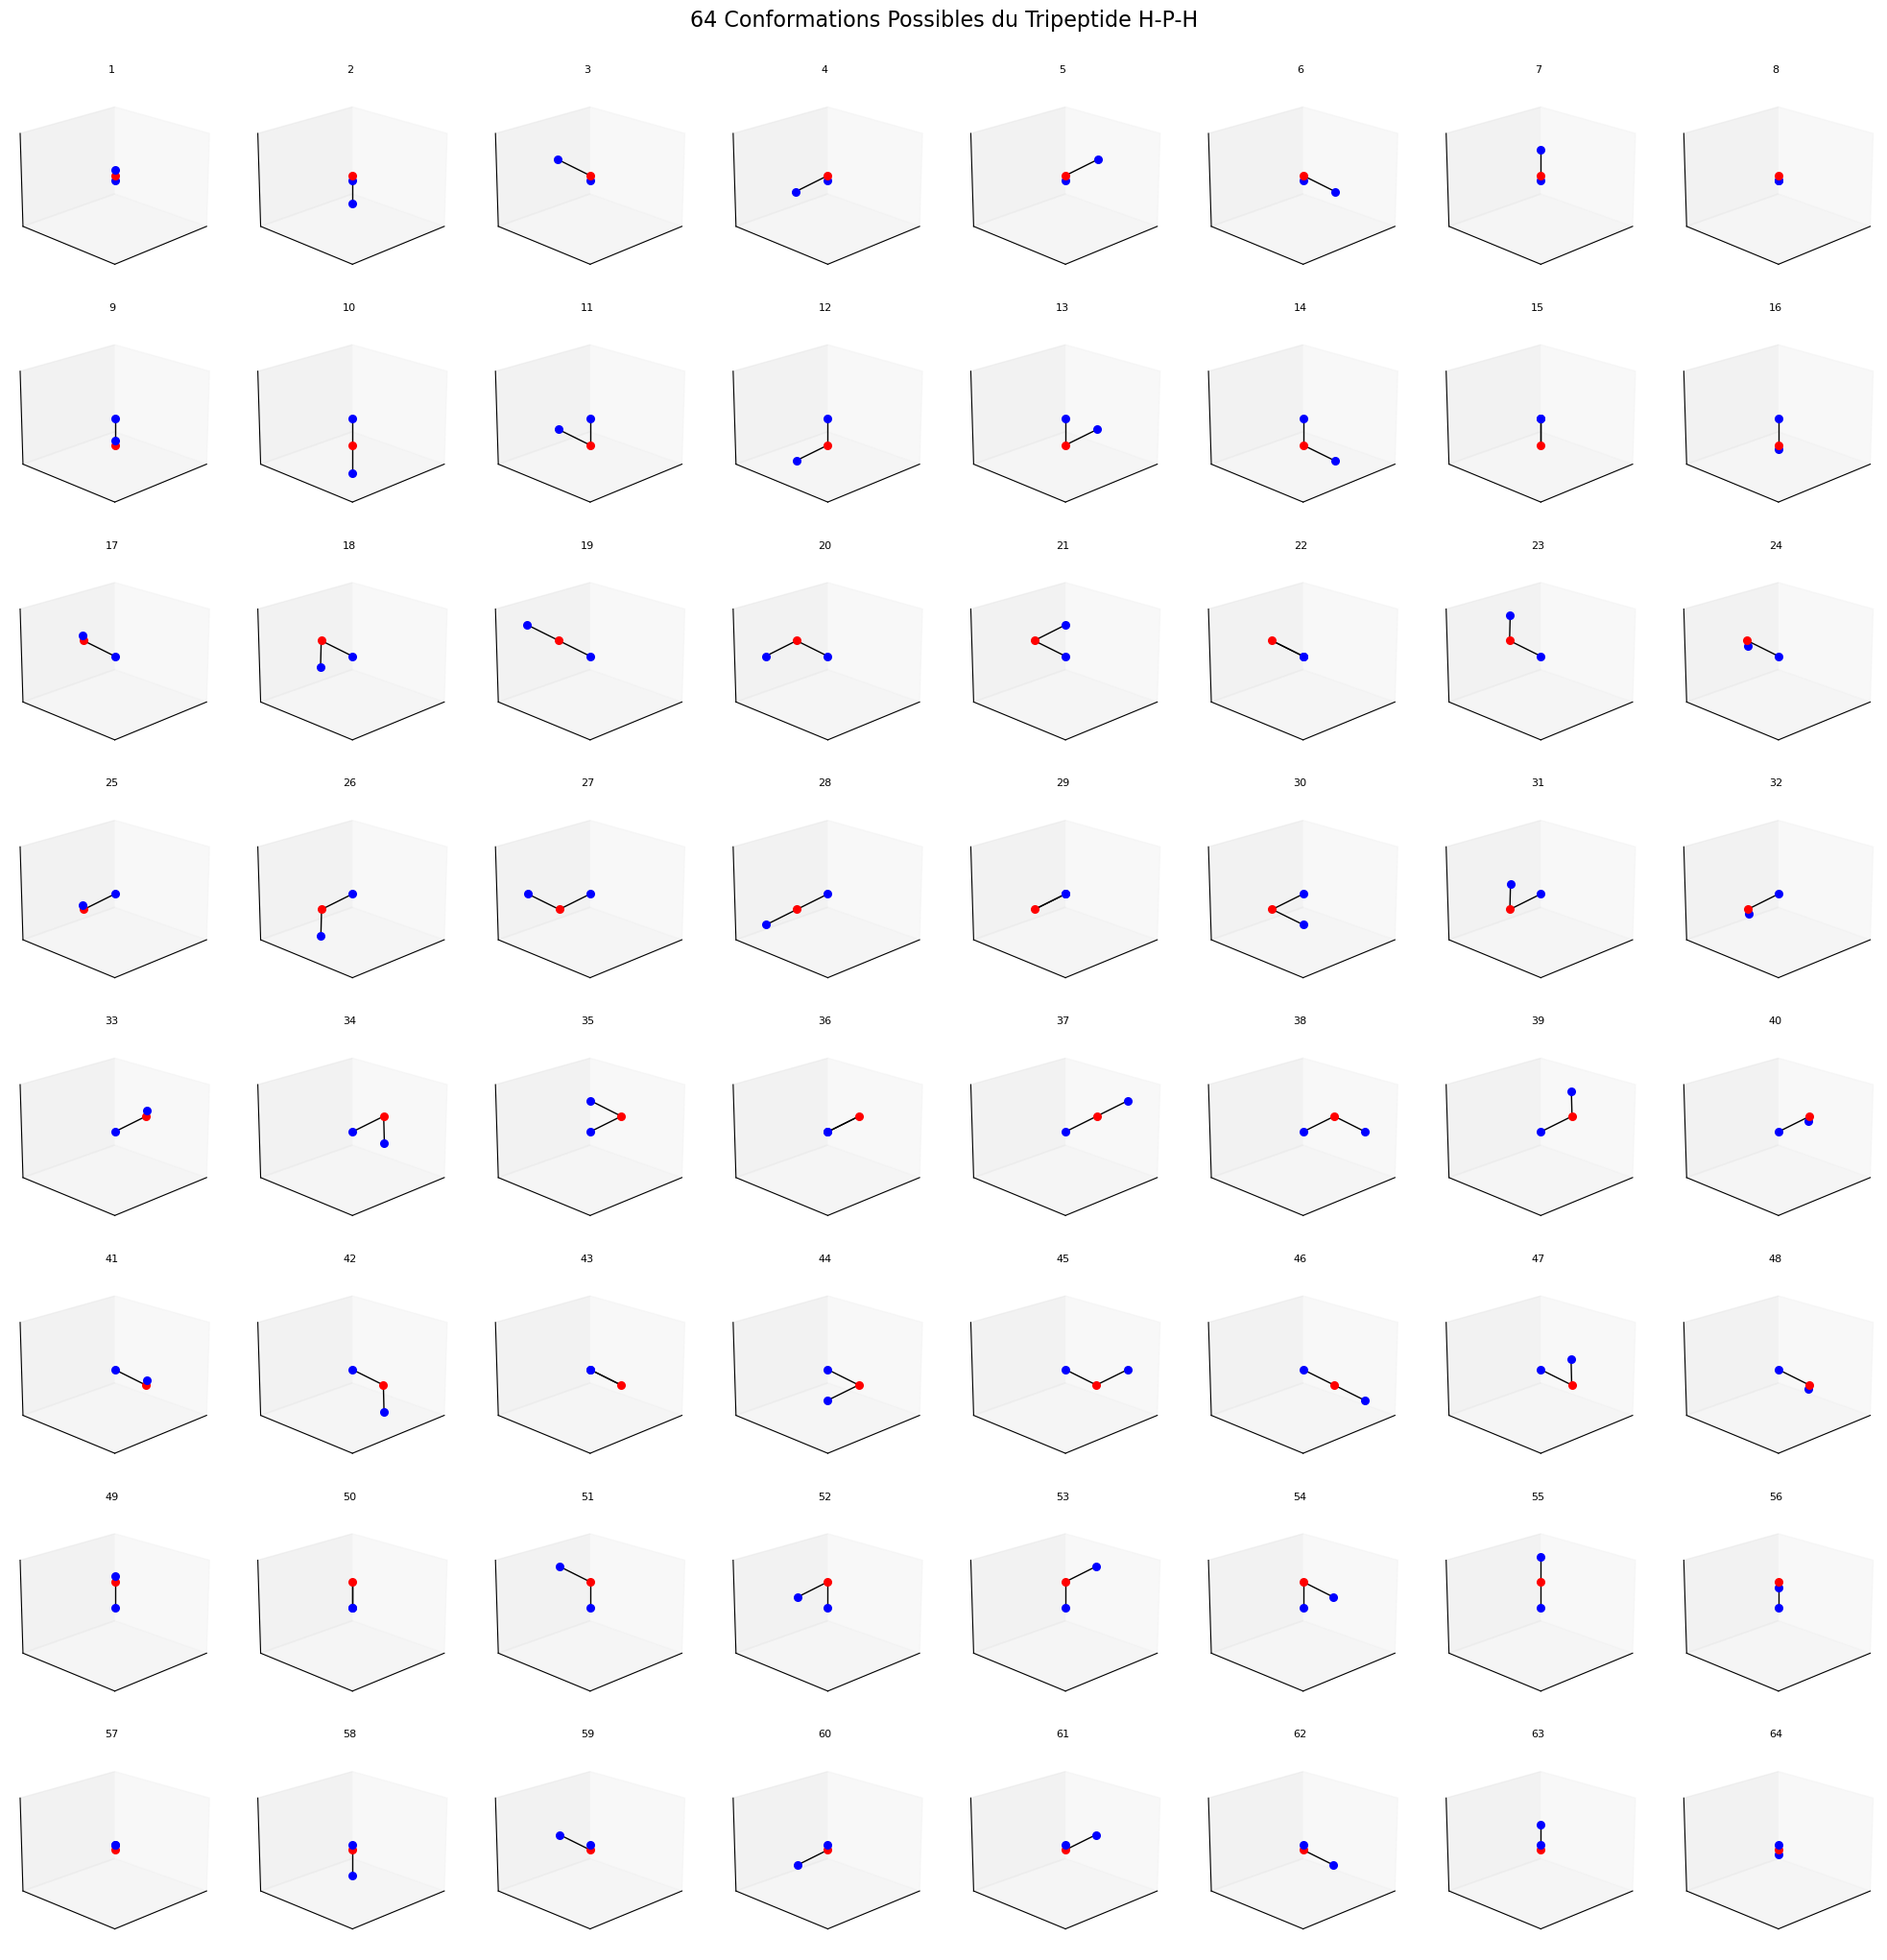

In [8]:
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1, projection='3d')
    conf = conformations[i]
    
    # Tracer les acides aminés
    ax.scatter(*conf[0], color='blue', s=30, depthshade=False)
    ax.scatter(*conf[1], color='red', s=30, depthshade=False)
    ax.scatter(*conf[2], color='blue', s=30, depthshade=False)
    
    # Tracer les liaisons
    ax.plot([conf[0][0], conf[1][0]], [conf[0][1], conf[1][1]], [conf[0][2], conf[1][2]], 
            'k-', linewidth=1)
    ax.plot([conf[1][0], conf[2][0]], [conf[1][1], conf[2][1]], [conf[1][2], conf[2][2]], 
            'k-', linewidth=1)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(f'{i+1}', fontsize=8)
    
    # Ajustement de la vue
    ax.view_init(elev=20, azim=45)
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])

plt.tight_layout()
plt.suptitle("64 Conformations Possibles du Tripeptide H-P-H", y=1.02, fontsize=16)
plt.show()